In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 58.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=30543451797e74285c59dbf047e83788a3b29aa8fa505e462b800da11a3dd29c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Download source data csv file

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Kindle_Store.csv

--2022-02-23 05:46:43--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Kindle_Store.csv
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130622468 (125M) [text/csv]
Saving to: ‘ratings_Kindle_Store.csv’

ratings_Kindle_Stor 100%[===================>] 124.57M  4.09MB/s    in 30s     

2022-02-23 05:47:14 (4.13 MB/s) - ‘ratings_Kindle_Store.csv’ saved [130622468/130622468]



Let's create a Spark session.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Let's initiate the Spark dataframe.

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
schema = StructType([
    StructField("user", StringType(), True),
    StructField("item", StringType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)
    ])

col_names=["user", "item", "rating", "timestamp"]
df = spark.read.csv('/content/ratings_Kindle_Store.csv', schema=schema, header=None)

Let's show the first 10 rows.

In [ ]:
df.show(10)

Let's check the number of null values in each of the columns.

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----+----+------+---------+
|user|item|rating|timestamp|
+----+----+------+---------+
|   0|   0|     0|        0|
+----+----+------+---------+



Due to user and item columns being strings, they will need to be converted to numeric. We will assign numbers starting with 1, to represent each unique user and item.

In [ ]:
user_count=df.select("user").distinct().count()
item_count=df.select("item").distinct().count()




In [ ]:
user_tab=df.select("user").sort("user", ascending=False).distinct()
item_tab=df.select("item").sort("item", ascending=False).distinct()

We will then append the column with numeric IDs for user and item.

In [ ]:
from pyspark.sql.functions import col, row_number, concat
from pyspark.sql.window import Window
df_user=user_tab.withColumn("user_id", row_number().over(Window().orderBy("user")))
df_item=item_tab.withColumn("item_id", row_number().over(Window().orderBy("item")))


In [ ]:
df_new=df.join(df_user, df.user==df_user.user, "inner").select(df["*"], df_user["user_id"])
df_new=df_new.join(df_item, df_new.item==df_item.item, "inner").select(df_new["*"], df_item["item_id"])

Let's see the first 30 rows now with user_id and item_id.

In [ ]:
df_new.show(30)

+--------------+----------+------+----------+-------+-------+
|          user|      item|rating| timestamp|user_id|item_id|
+--------------+----------+------+----------+-------+-------+
|A185HGLJQOH1K7|B0002IQ15S|   4.0|1126224000|  86914|      2|
|A2RWCDXMX1C597|B0002IQ15S|   4.0|1172448000| 662419|      2|
|A13F6NVPW73ORB|B0002IQ15S|   2.0|1212364800|  37743|      2|
| AU8DH6AOA1YOJ|B0002IQ15S|   5.0|1102291200|1347790|      2|
|A2FN6JKET6O4Y5|B000F83STC|   4.0|1384905600| 536045|      3|
|A1F6404F1VG29J|B000F83SZQ|   5.0|1399248000| 159374|      4|
|A3DE6XGZ2EPADS|B000F83SZQ|   4.0|1395446400| 884445|      4|
|A3SPTOKDG7WBLN|B000F83SZQ|   4.0|1395187200|1042370|      4|
| A795DMNCJILA6|B000F83SZQ|   4.0|1396569600|1111909|      4|
| AN0N05A9LIJEQ|B000F83SZQ|   4.0|1388966400|1273696|      4|
|A1FV0SX13TWVXQ|B000F83SZQ|   5.0|1392768000| 166495|      4|
|A1M2PI6B4KY4SD|B000F83SZQ|   5.0|1393372800| 230969|      4|
|A1RK2OCZDSGC6R|B000F83SZQ|   4.0|1401062400| 287405|      4|
|A2HSAKH

Let's see which items have the most reviews. (Top 20)

In [ ]:
review_count=df_new.groupBy("item").count().sort("count", ascending=False)
review_count.show(20)

+----------+-----+
|      item|count|
+----------+-----+
|B006GWO5WK|12226|
|B007R5YDYA| 9907|
|B005DOK8NW| 4735|
|B00825BZUY| 3797|
|B0093MU7QS| 3290|
|B00902SFC4| 2854|
|B006YC7A0Q| 2793|
|B006GWO5NE| 2199|
|B006P5CH1O| 2141|
|B00CATSONE| 2117|
|B00BTIDW4S| 2030|
|B008GGH4FY| 1898|
|B00DFIE80W| 1823|
|B006PJ3UKC| 1809|
|B008DVVLYW| 1807|
|B004JXVOD6| 1620|
|B006BGZJJ4| 1562|
|B00E86ENEQ| 1488|
|B007URVZJ6| 1475|
|B005ME39HU| 1438|
+----------+-----+
only showing top 20 rows



Let's see which items have the highest average reviews. (Top 20)

In [ ]:
review_avg=df_new.groupBy("item").avg("rating").sort("avg(rating)", ascending=False)
review_avg.show(20)

+----------+-----------+
|      item|avg(rating)|
+----------+-----------+
|B000FBF8DS|        5.0|
|B000FA66LM|        5.0|
|B000F83TEQ|        5.0|
|B000FA5M3K|        5.0|
|B000FA5S98|        5.0|
|B000FA5UXC|        5.0|
|B000FA5Z3W|        5.0|
|B000FA63OM|        5.0|
|B000FBF87E|        5.0|
|B000FA5V4A|        5.0|
|B000FBF8LU|        5.0|
|B000FBF9KA|        5.0|
|B000FBFCRA|        5.0|
|B000FBFF5E|        5.0|
|B000FBFFQI|        5.0|
|B000FBFIEM|        5.0|
|B000FBFMH0|        5.0|
|B000FBFMUM|        5.0|
|B000FBFNXI|        5.0|
|B000FBFP04|        5.0|
+----------+-----------+
only showing top 20 rows



The table show that the top 20 items all have an average rating of 5.0. This is likely when the number of review is low. To see how review count is correlated with average rating, we will merge the two tables.

In [ ]:
rating_count=review_count.join(review_avg, review_count.item==review_avg.item, "inner").select(review_count["*"], review_avg["avg(rating)"])
rating_count.show(30)

+----------+-----+------------------+
|      item|count|       avg(rating)|
+----------+-----+------------------+
|1603420304|   87| 4.471264367816092|
|B0002IQ15S|    4|              3.75|
|B000F83STC|    1|               4.0|
|B000F83SZQ|   10|               4.4|
|B000F83TEQ|    1|               5.0|
|B000FA5KJQ|    1|               1.0|
|B000FA5KKA|    2|               4.5|
|B000FA5M3K|    1|               5.0|
|B000FA5MQ2|    1|               4.0|
|B000FA5NSO|    1|               4.0|
|B000FA5O8I|    1|               4.0|
|B000FA5PV4|   25|               4.6|
|B000FA5QBS|    6|3.6666666666666665|
|B000FA5RE4|    1|               1.0|
|B000FA5RY4|    4|               4.5|
|B000FA5S98|    4|               5.0|
|B000FA5SHK|    1|               2.0|
|B000FA5T4W|    2|               4.0|
|B000FA5TOM|   10|               4.1|
|B000FA5UXC|    1|               5.0|
|B000FA5V2C|    1|               4.0|
|B000FA5V4A|    1|               5.0|
|B000FA5WOY|    1|               4.0|
|B000FA5X16|

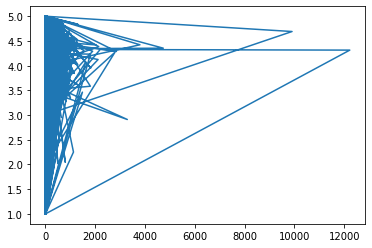

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rating_count.select("count").collect(),rating_count.select("avg(rating)").collect() )

Let's split the data into 80% training and 20% testing and then train the model.

In [ ]:
(training, test) = df_new.randomSplit([0.8, 0.2])

als = ALS(maxIter=5, regParam=0.09, rank=25, userCol="user_id", itemCol="item_id", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)


Let's evaluate the model on the test data in term of root mean square error.

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root mean square error is " + str(rmse))

Root mean square error is 1.4835232524535922


The following will output the top 10 recommended items for each user.

In [ ]:
users = df_new.select(als.getUserCol()).distinct().limit(3)

In [ ]:
model.recommendForUserSubset(users, 10).show()